In [1]:
! pip install zfpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 8.8 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn.utils.prune as prune
import torchvision.models as models
from torchvision.models import VGG11_Weights
import numpy as np
import zfpy
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from tabulate import tabulate
import pandas as pd
import pickle
import os
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
TRAIN = True
VALIDATION_JSON = 'validation_data.json'
MODEL_PATH = '/kaggle/working/org_model.pkl'

### Helper Functions

In [4]:
def print_statistics(model):
    all_statistics = []
    for name, param in model.named_parameters():
        if 'weight' in name:
            weights = param.data.flatten()
            statistics = {
                'Layer': name,
                'Mean': weights.mean().item(),
                'Standard Deviation': weights.std().item(),
                'Min': weights.min().item(),
                'Max': weights.max().item()
            }
            all_statistics.append(statistics)
    
    df = pd.DataFrame(all_statistics)
    return df

In [5]:
def plot_weight_distribution(model, tolerance=1e-3, base=False):
    model = model.cpu()
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    if base:
        fig.suptitle(f'Weight Distribution of Original Features Weights')
    else:
        fig.suptitle(f'Weight Distribution of only Features Weights (Tolerance {tolerance})')

    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)
    i = 0
    for name, param in model.named_parameters():
        if 'weight' in name and 'features' in name:
            weights = param.data.flatten()
#             .to(torch.device('cpu'))
            
            # Plot histogram for this layer
            ax = axes[i//4, i%4]
            sns.histplot(weights, bins=100, kde=True, ax=ax)
            ax.set_title(f'{name}')
            ax.set_xlabel('Weight Value')
            ax.set_ylabel('Frequency')
            
            i += 1

In [6]:
def save_pkl(file: str, state_dict: dict) -> float:
    with open(file, 'wb') as f:
        pickle.dump(state_dict, f)
    return os.path.getsize(file)
        
def load_pkl(file: str) -> dict:
    with open(file, 'rb') as f:
        return pickle.load(f)

### Train VGG11

#### Dataset

In [7]:
def data_loader(data_dir,
                batch_size,
                random_seed=42,
                valid_size=0.1,
                shuffle=True,
                test=False):
      
    with pd.option_context('mode.use_inf_as_na', False):
        normalize = transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.2023, 0.1994, 0.2010],
        )

        # define transforms
        transform = transforms.Compose([
                transforms.Resize((227,227)),
                transforms.ToTensor(),
                normalize,
        ])
    
        if test:
            dataset = datasets.CIFAR100(
              root=data_dir, train=False,
              download=True, transform=transform,
            )

            data_loader = torch.utils.data.DataLoader(
                dataset, batch_size=batch_size, shuffle=shuffle
            )

            return data_loader

        # load the dataset
        train_dataset = datasets.CIFAR100(
            root=data_dir, train=True,
            download=True, transform=transform,
        )

        valid_dataset = datasets.CIFAR10(
            root=data_dir, train=True,
            download=True, transform=transform,
        )

        num_train = len(train_dataset)
        indices = list(range(num_train))
        split = int(np.floor(valid_size * num_train))

        if shuffle:
            np.random.seed(random_seed)
            np.random.shuffle(indices)

        train_idx, valid_idx = indices[split:], indices[:split]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=batch_size, sampler=train_sampler)

        valid_loader = torch.utils.data.DataLoader(
            valid_dataset, batch_size=batch_size, sampler=valid_sampler)

        return (train_loader, valid_loader)


# CIFAR100 dataset
if TRAIN:
    train_loader, valid_loader = data_loader(data_dir='./data', batch_size=64)
    
    test_loader = data_loader(data_dir='./data',
                          batch_size=64,
                          test=True)

def test_accuracy(model):
    with torch.no_grad():
        correct = 0
        total = 0
        i = 0
        
#         return 100*3/5
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
            
            i += 1
#             if i == 1:
#                 break
            
        return 100 * correct / total

/tmp/ipykernel_24/4278625807.py:8: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', False):


100%|██████████| 169001437/169001437 [00:02<00:00, 59559585.45it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data


100%|██████████| 170498071/170498071 [00:02<00:00, 57889987.05it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/tmp/ipykernel_24/4278625807.py:8: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', False):


Files already downloaded and verified


#### Training

In [8]:
if TRAIN:
    model = models.vgg11(weights=VGG11_Weights.IMAGENET1K_V1).to(device)  
    num_classes = 100
    num_epochs = 5
    batch_size = 32
    learning_rate = 0.005


    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)
    total_step = len(train_loader)

    for epoch in range(num_epochs):
        model.train()
        for i, (images, labels) in enumerate(train_loader):  
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if i % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                            .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        
        # Validation
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in valid_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                del images, labels, outputs
        
            print('Accuracy of the network on the {} validation images: {} % (Epoch {})'.format(5000, 100 * correct / total, epoch+1))
else:
#     model = models.vgg11(weights=VGG11_Weights.IMAGENET1K_V1)
    model = models.vgg11()
    model.load_state_dict(load_pkl(MODEL_PATH))
    model.eval()

Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:03<00:00, 145MB/s]


Epoch [1/5], Step [1/704], Loss: 11.8130
Epoch [1/5], Step [101/704], Loss: 4.7393
Epoch [1/5], Step [201/704], Loss: 4.1900
Epoch [1/5], Step [301/704], Loss: 4.0338
Epoch [1/5], Step [401/704], Loss: 3.7369
Epoch [1/5], Step [501/704], Loss: 3.3311
Epoch [1/5], Step [601/704], Loss: 3.1279
Epoch [1/5], Step [701/704], Loss: 3.0002
Accuracy of the network on the 5000 validation images: 1.44 % (Epoch 1)
Epoch [2/5], Step [1/704], Loss: 3.0868
Epoch [2/5], Step [101/704], Loss: 2.5315
Epoch [2/5], Step [201/704], Loss: 2.0931
Epoch [2/5], Step [301/704], Loss: 2.1985
Epoch [2/5], Step [401/704], Loss: 2.1002
Epoch [2/5], Step [501/704], Loss: 1.8355
Epoch [2/5], Step [601/704], Loss: 2.1174
Epoch [2/5], Step [701/704], Loss: 2.5978
Accuracy of the network on the 5000 validation images: 0.44 % (Epoch 2)
Epoch [3/5], Step [1/704], Loss: 1.7928
Epoch [3/5], Step [101/704], Loss: 1.8192
Epoch [3/5], Step [201/704], Loss: 2.1175
Epoch [3/5], Step [301/704], Loss: 1.7801
Epoch [3/5], Step [40

### Pruning

In [9]:
def calculate_sparsity(model):
    total_params = 0
    zero_params = 0

    for param in model.parameters():
        total_params += param.numel()
        zero_params += torch.sum(param == 0).item()

    sparsity = zero_params / total_params
    return sparsity

# parameters_to_prune = (
#     (model.features[0], 'weight'),
#     (model.features[3], 'weight'),
#     (model.features[6], 'weight'),
#     (model.features[8], 'weight'),
#     (model.features[11], 'weight'),
#     (model.features[13], 'weight'),
#     (model.features[16], 'weight'),
#     (model.features[18], 'weight')
# )

# parameters_to_prune = []
# for name, module in model.named_modules():
#     if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
#         parameters_to_prune.append((module, 'weight'))
#         if module.bias is not None:
#             parameters_to_prune.append((module, 'bias'))


# prune.global_unstructured(
#     parameters_to_prune,
#     pruning_method=prune.L1Unstructured,
#     amount=0.2,
# )

# for layer, param in parameters_to_prune:
#     prune.remove(layer, param)

print('Model Sparsity:', calculate_sparsity(model))

Model Sparsity: 0.0


### Distribution of Original Weights

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

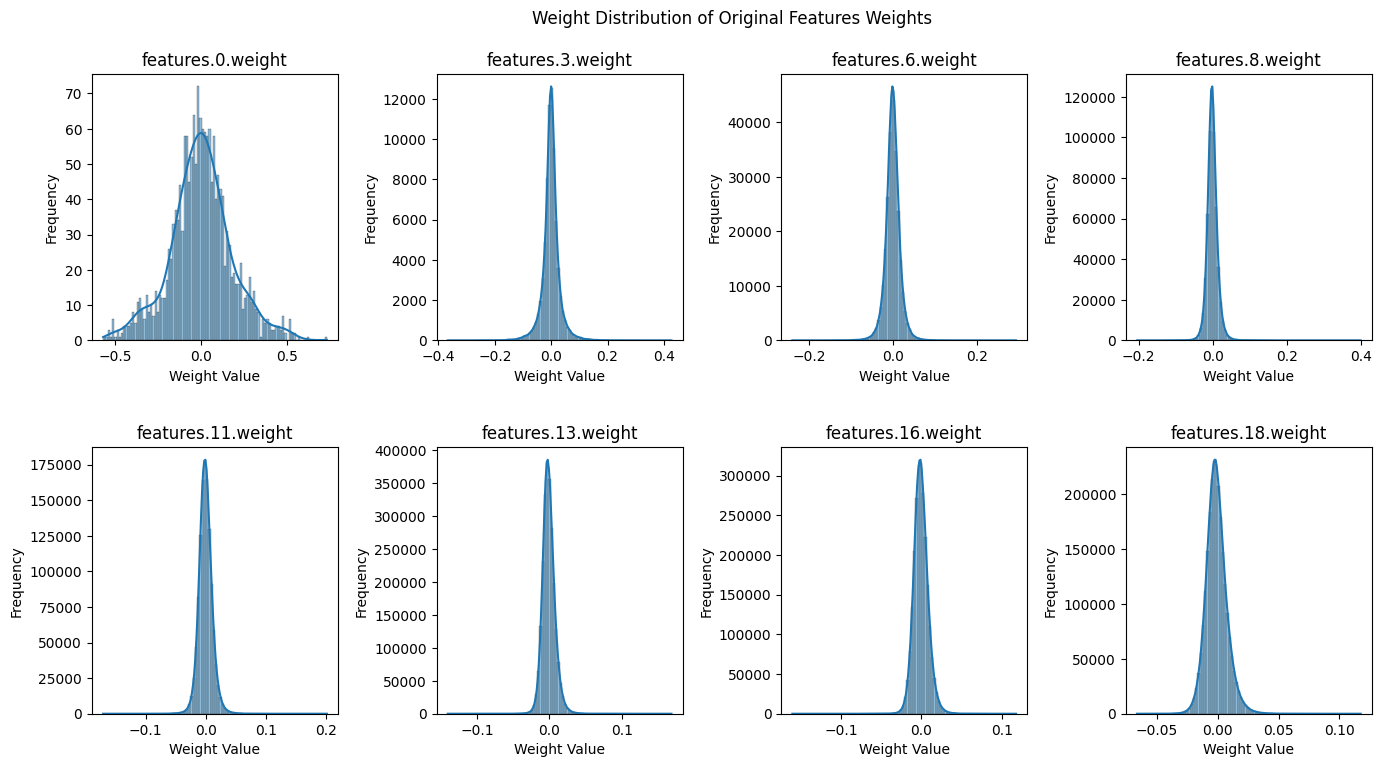

In [10]:
# classifier.0.weight 102760448
# classifier.3.weight 16777216
# classifier.6.weight 4096000
plot_weight_distribution(model, base=True)

In [11]:
orig_stats = print_statistics(model)
orig_stats

,Layer,Mean,Standard Deviation,Min,Max
0,features.0.weight,-7.582722e-04,0.182424,-0.570302,0.731371
1,features.3.weight,-6.802429e-04,0.031674,-0.367251,0.426969
2,features.6.weight,-5.563891e-04,0.017858,-0.240306,0.294179
3,features.8.weight,-1.011221e-03,0.014130,-0.204491,0.399610
4,features.11.weight,-6.103066e-04,0.011338,-0.171047,0.201409
5,features.13.weight,-1.027348e-03,0.008717,-0.140551,0.168622
6,features.16.weight,-5.451902e-04,0.009037,-0.160348,0.117801
7,features.18.weight,-1.144449e-03,0.008684,-0.066573,0.117496
8,classifier.0.weight,-1.115231e-04,0.002562,-0.026098,0.038281
9,classifier.3.weight,-2.734229e-04,0.004950,-0.028037,0.037215


### Compress and Decompress functions using ZFP

In [12]:
# Function to compress tensor using ZFP
def compress_tensor(tensor, tolerance=1e-3):
    array = tensor.cpu().numpy()  # Convert tensor to numpy array
    compressed = zfpy.compress_numpy(array, tolerance=tolerance)
    return compressed

# Function to decompress tensor using ZFP
def decompress_tensor(compressed, original_shape):
    decompressed = zfpy.decompress_numpy(compressed)
    tensor = torch.tensor(decompressed).reshape(original_shape)
    return tensor

### Perform Validation Testing

In [13]:
model = model.to(device)

if TRAIN:
    org_size = save_pkl('org_model.pkl', model.state_dict())
    org_data = {
        'tolerance': 0,
        'test_accuracy': test_accuracy(model),
        'compression_ratio': 1,
        'model_size': org_size / 1024**2,  # Size in MB
        'stats': orig_stats
    }
    
    print(f'Test Accuracy: {org_data["test_accuracy"]}')

Test Accuracy: 57.78


Processing:   0%|          | 0/27 [00:00<?, ?item/s]

0 <class 'pandas.core.frame.DataFrame'>


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

1 <class 'pandas.core.frame.DataFrame'>


Processing:   7%|▋         | 2/27 [02:05<23:49, 57.19s/item]

2 <class 'pandas.core.frame.DataFrame'>


Processing:  11%|█         | 3/27 [02:36<18:00, 45.03s/item]

3 <class 'pandas.core.frame.DataFrame'>


Processing:  15%|█▍        | 4/27 [03:07<15:08, 39.50s/item]

4 <class 'pandas.core.frame.DataFrame'>


Processing:  19%|█▊        | 5/27 [03:39<13:27, 36.70s/item]

5 <class 'pandas.core.frame.DataFrame'>


Processing:  22%|██▏       | 6/27 [04:12<12:22, 35.34s/item]

6 <class 'pandas.core.frame.DataFrame'>


Processing:  26%|██▌       | 7/27 [04:47<11:48, 35.41s/item]

7 <class 'pandas.core.frame.DataFrame'>


Processing:  30%|██▉       | 8/27 [05:23<11:17, 35.63s/item]

8 <class 'pandas.core.frame.DataFrame'>


Processing:  33%|███▎      | 9/27 [05:58<10:37, 35.41s/item]

9 <class 'pandas.core.frame.DataFrame'>


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

10 <class 'pandas.core.frame.DataFrame'>


Processing:  41%|████      | 11/27 [08:15<13:14, 49.64s/item]

11 <class 'pandas.core.frame.DataFrame'>


Processing:  44%|████▍     | 12/27 [08:51<11:23, 45.57s/item]

12 <class 'pandas.core.frame.DataFrame'>


Processing:  48%|████▊     | 13/27 [09:28<09:59, 42.84s/item]

13 <class 'pandas.core.frame.DataFrame'>


Processing:  52%|█████▏    | 14/27 [10:05<08:54, 41.10s/item]

14 <class 'pandas.core.frame.DataFrame'>


Processing:  56%|█████▌    | 15/27 [10:42<07:58, 39.90s/item]

15 <class 'pandas.core.frame.DataFrame'>


Processing:  59%|█████▉    | 16/27 [11:20<07:11, 39.25s/item]

16 <class 'pandas.core.frame.DataFrame'>


Processing:  63%|██████▎   | 17/27 [11:58<06:29, 38.93s/item]

17 <class 'pandas.core.frame.DataFrame'>


Processing:  67%|██████▋   | 18/27 [12:37<05:49, 38.84s/item]

18 <class 'pandas.core.frame.DataFrame'>


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

19 <class 'pandas.core.frame.DataFrame'>


Processing:  74%|███████▍  | 20/27 [15:01<06:09, 52.85s/item]

20 <class 'pandas.core.frame.DataFrame'>


Processing:  78%|███████▊  | 21/27 [15:41<04:53, 48.96s/item]

21 <class 'pandas.core.frame.DataFrame'>


Processing:  81%|████████▏ | 22/27 [16:21<03:51, 46.38s/item]

22 <class 'pandas.core.frame.DataFrame'>


Processing:  85%|████████▌ | 23/27 [17:02<02:58, 44.74s/item]

23 <class 'pandas.core.frame.DataFrame'>


Processing:  89%|████████▉ | 24/27 [17:43<02:11, 43.71s/item]

24 <class 'pandas.core.frame.DataFrame'>


Processing:  93%|█████████▎| 25/27 [18:25<01:26, 43.16s/item]

25 <class 'pandas.core.frame.DataFrame'>


Processing:  96%|█████████▋| 26/27 [19:07<00:42, 42.86s/item]

26 <class 'pandas.core.frame.DataFrame'>


Processing: 100%|██████████| 27/27 [19:50<00:00, 44.10s/item]


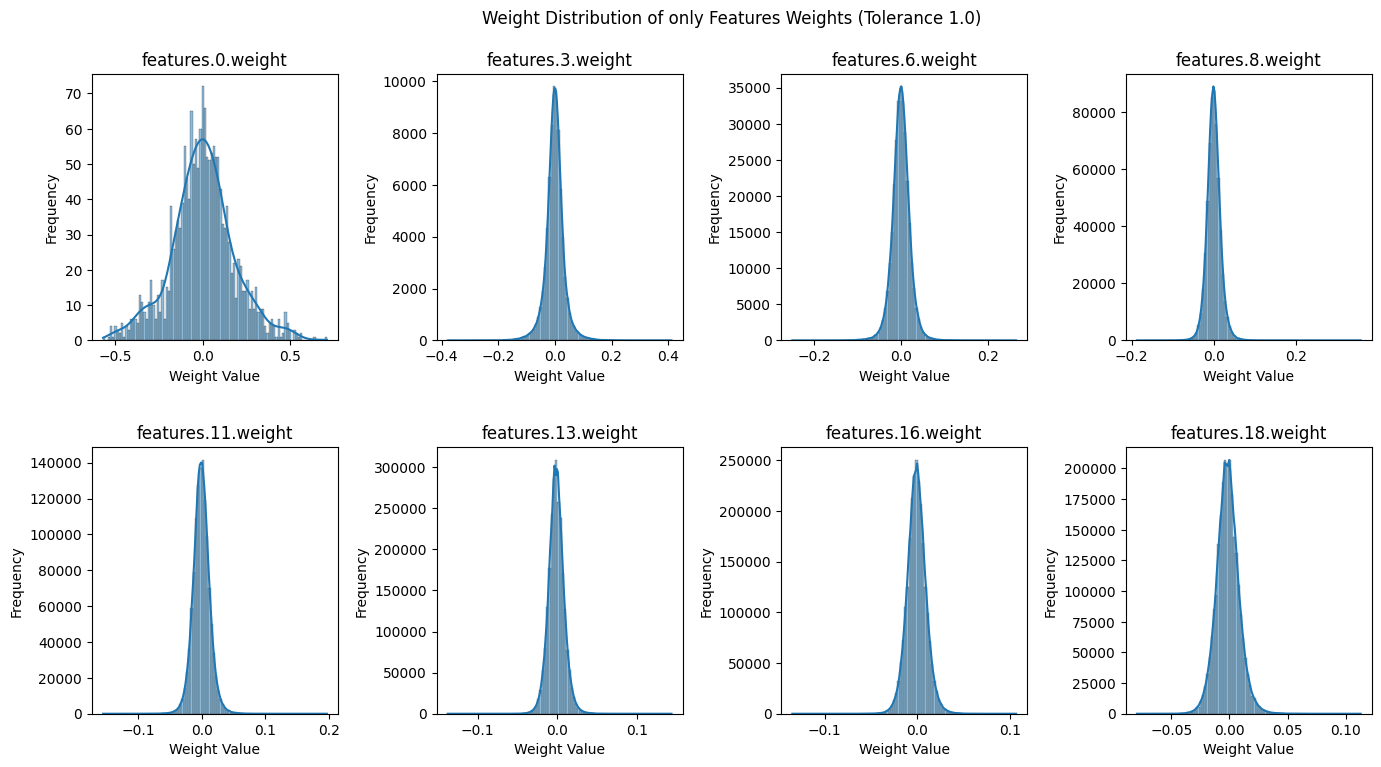

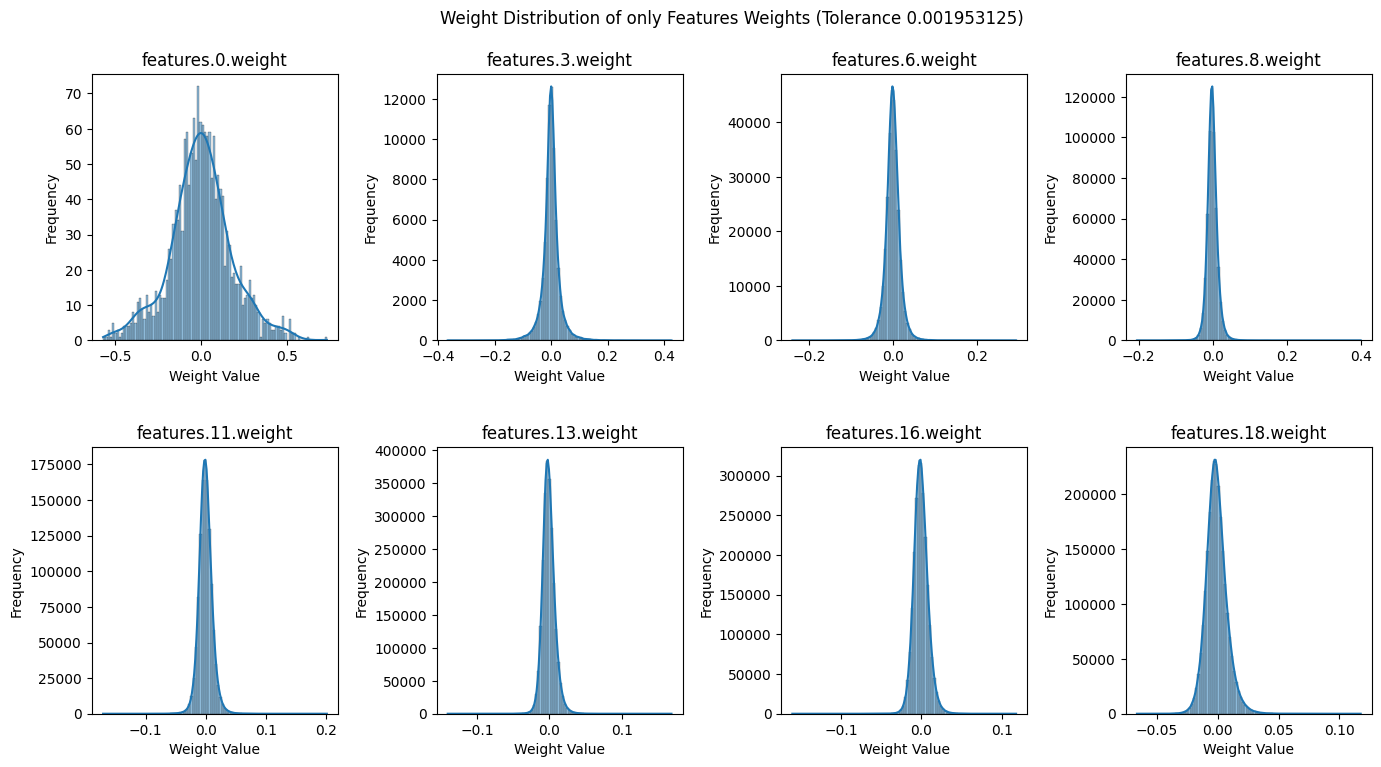

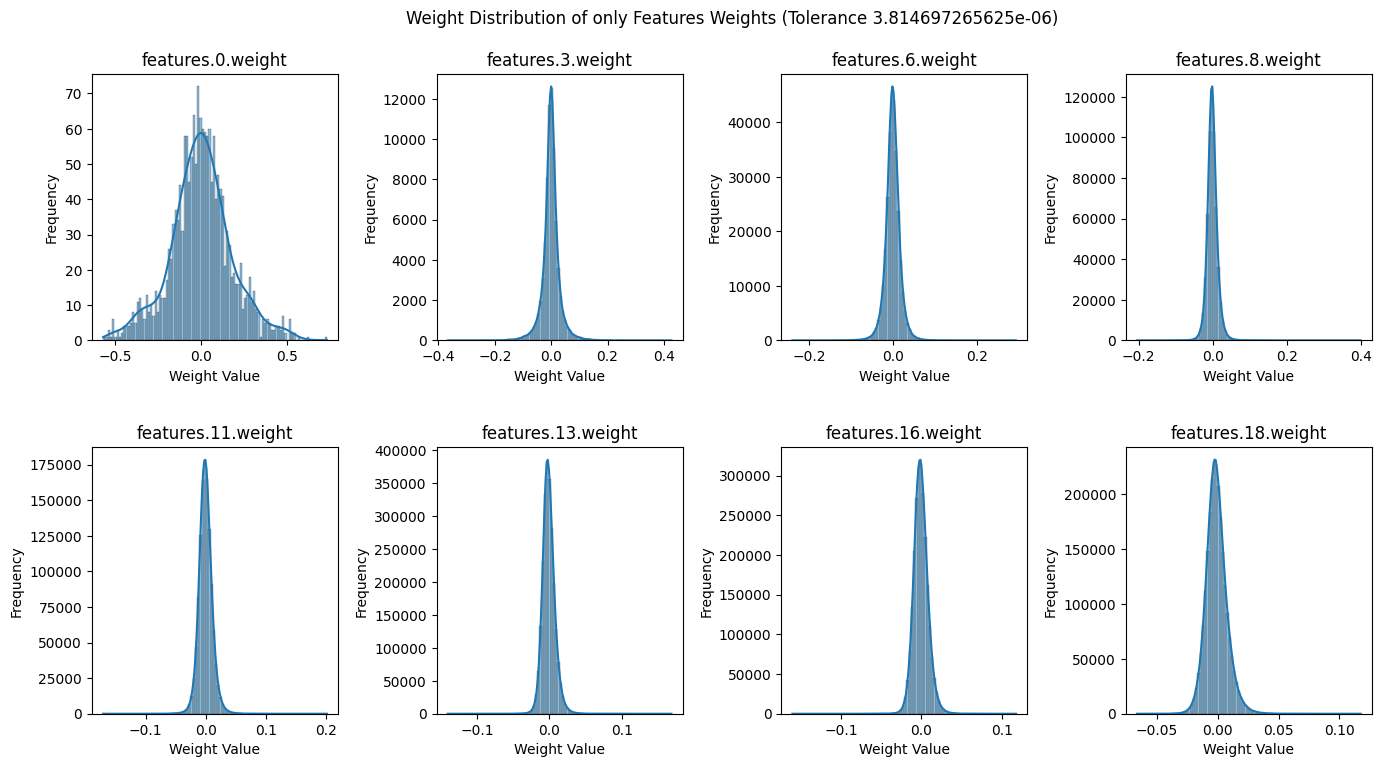

In [14]:
tolerance_values = [1/2**i for i in range(0, 27)]
# tolerance_values = [1/2**i for i in range(0, 2)]

if TRAIN:
    # decompressed_model_stats = []
    results = []

    for i, tolerance in tqdm(enumerate(tolerance_values), total=len(tolerance_values), desc="Processing", unit="item"):
        copied_model = copy.deepcopy(model)

        # Compress weights
        compressed_weights = {}
        for name, param in copied_model.named_parameters():
            if param.requires_grad:
                compressed_weights[name] = compress_tensor(param.data, tolerance=tolerance)

        pkl_path = f'zfp_model_{tolerance}.pkl'
        zfp_size = save_pkl(pkl_path, compressed_weights)

        # Decompress weights
        for name, param in copied_model.named_parameters():
            if param.requires_grad:
                param.data = decompress_tensor(compressed_weights[name], param.data.shape)
        
        print(i, type(print_statistics(copied_model)))
        
        results.append({
            'tolerance': tolerance,
            'test_accuracy': test_accuracy(copied_model.to(device)),
#             'test_accuracy': 0.25,
            'compression_ratio': org_size / zfp_size,
            'model_size': zfp_size / 1024**2,  # Size in MB
            'stats': print_statistics(copied_model)
        })

    #     decompressed_model_stats.append(print_statistics(copied_model))

        if i % 9 == 0:
#             with pd.option_context('mode.use_inf_as_na', True):
            plot_weight_distribution(copied_model, tolerance=tolerance)

### Save or Load Results

In [15]:
import json
from io import StringIO

if TRAIN:
    # save results
    results_copy = copy.deepcopy(results)
    org_data_copy = copy.deepcopy(org_data)
    results_copy.append(org_data_copy)
    
    for r in results_copy:
        r['stats'] = r['stats'].to_json(orient='records')
        
    with open(VALIDATION_JSON, 'w') as json_file:
        json.dump(results_copy, json_file, indent=4)  
else:
    # load results
    with open(VALIDATION_JSON, 'r') as json_file:
        results = json.load(json_file)
        
        for r in results:
            r['stats'] = pd.read_json(StringIO(r['stats']), orient='records')
            
        org_data = results.pop()

# print(results[0].keys())
# print(type(org_data['stats']))

### Graphing Tolerance vs Accuracy, Compression Ratio, Model Size

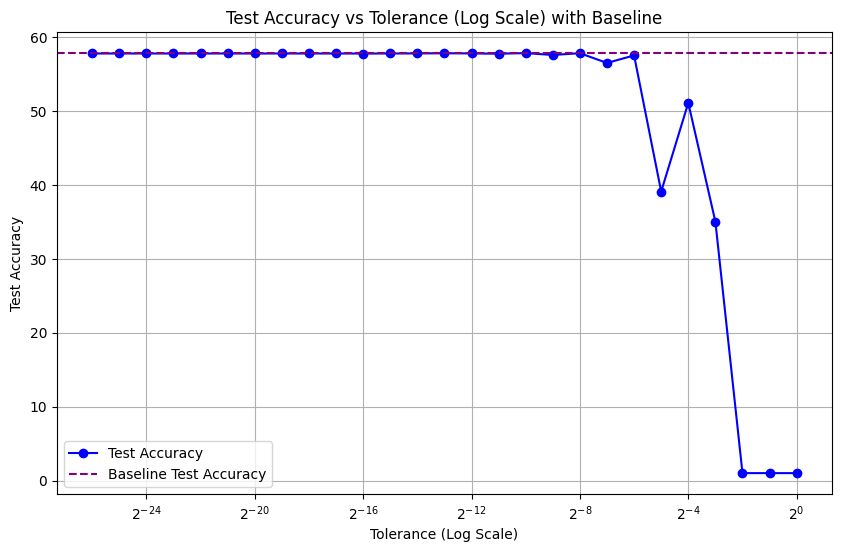

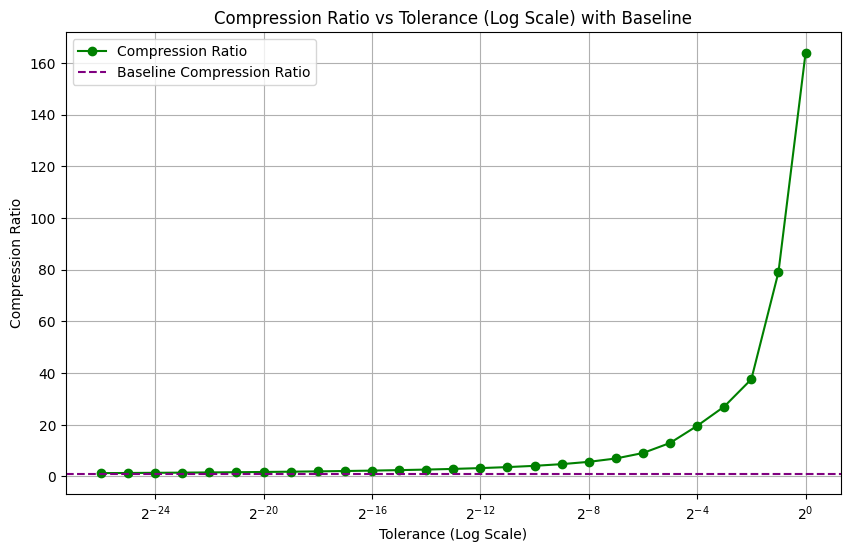

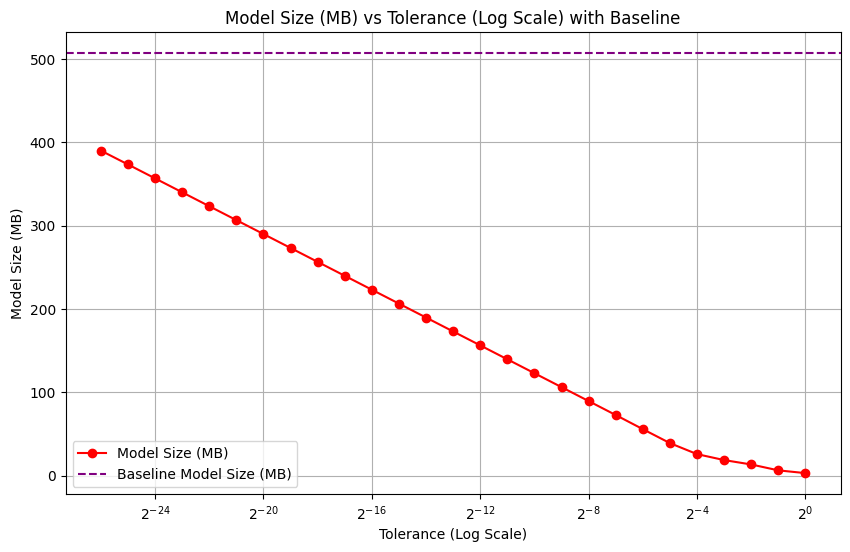

In [16]:
tolerances = [result["tolerance"] for result in results]
accuracy = [result["test_accuracy"] for result in results]
compression_ratios = [result["compression_ratio"] for result in results]
model_sizes = [result["model_size"] for result in results]

data = [
    (accuracy, org_data['test_accuracy'], 'blue', 'Test Accuracy'),
    (compression_ratios, org_data['compression_ratio'], 'green', 'Compression Ratio'),
    (model_sizes, org_data['model_size'], 'red', 'Model Size (MB)'),
]

for values, baseline, color, label in data:
    plt.figure(figsize=(10, 6))

    plt.plot(tolerances, values, color=color, marker='o', label=label)
    plt.axhline(y=baseline, color='purple', linestyle='--', label=f'Baseline {label}')

    plt.title(f'{label} vs Tolerance (Log Scale) with Baseline')
    plt.xscale('log', base=2)
    plt.xlabel('Tolerance (Log Scale)')
    plt.ylabel(label)
    plt.legend()
    plt.grid(True)

    plt.show()

### Comparing Mean, Standard Deviation, Min, Max

In [17]:
def compare_model_stats(model, copied_model):
    res = pd.DataFrame()
    res['Layer'] = model['Layer']
    res['MSE Mean'] = (model['Mean'] - copied_model['Mean'])**2
    res['MSE SD'] = (model['Standard Deviation'] - copied_model['Standard Deviation'])**2
    res['MSE Min'] = (model['Min'] - copied_model['Min'])**2
    res['MSE Max'] = (model['Max'] - copied_model['Max'])**2
    
    return res

abs_mean = []
abs_sd = []
abs_min = []
abs_max = []
orig_stats = org_data['stats']

for tolerance, model_data in zip(tolerances, results):
    comp = compare_model_stats(orig_stats, model_data['stats'])
    
    abs_mean.append(comp['MSE Mean'].mean())
    abs_sd.append(comp['MSE SD'].mean())  
    abs_min.append(comp['MSE Min'].mean())
    abs_max.append(comp['MSE Max'].mean())

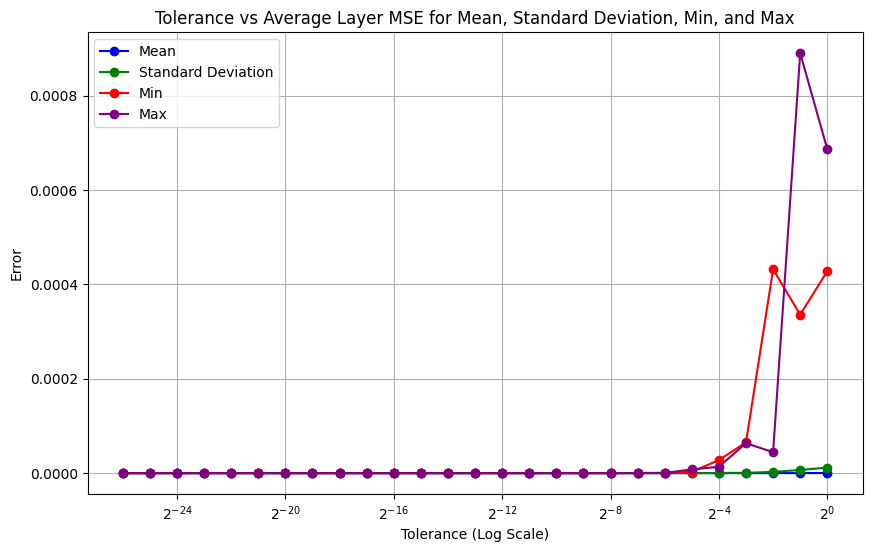

In [18]:
data = [
    (abs_mean, 'blue', 'Mean'),
    (abs_sd, 'green', 'Standard Deviation'),
    (abs_min, 'red', 'Min'),
    (abs_max, 'purple', 'Max')
]

plt.figure(figsize=(10, 6))
plt.title(f'Tolerance vs Average Layer MSE for Mean, Standard Deviation, Min, and Max')
plt.xscale('log', base=2)
plt.xlabel('Tolerance (Log Scale)')
plt.ylabel('Error')

for values, color, label in data:
    plt.plot(tolerances, values, color=color, marker='o', label=label)
    

plt.legend()
plt.grid(True)
plt.show()

## Resources - Works Cited
- https://blog.paperspace.com/vgg-from-scratch-pytorch/
- https://pypi.org/project/zfpy/
- https://pytorch.org/hub/pytorch_vision_vgg/
- https://github.com/alex-grindrod/eblc-model-compression
- https://github.com/LLNL/zfp